# Guided Project: Predicting Bike Rentals

In [2]:
import pandas as pd
import numpy as np

In [3]:
bike_rentals=pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


We'll convert dteday to Datetime Object

In [5]:
bike_rentals['dteday'] = pd.to_datetime(bike_rentals['dteday'])
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(12)
memory usage: 2.3 MB


Now, we'll display 'cnt' distribution with a histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8242d07c88>]],
      dtype=object)

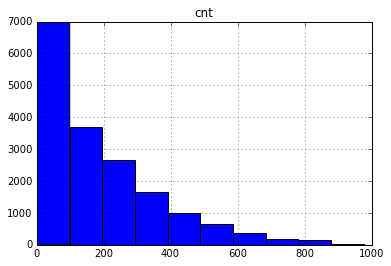

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals.hist(column='cnt')

According to the histogram the cnt column is skewed to the right. About 40% of rentals numbers are less than 100. let's find out the columns which have correlation higher than 0.3 with cnt column.

**Now we'll check correlation**

In [7]:
corr=abs(bike_rentals.corr()['cnt']).sort_values(ascending=False)
corr[corr>0.3]

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
Name: cnt, dtype: float64

Excluding registered and casual columns since cnt is the sum of them, these are the columns that have high correlations with the cnt column:

* **temperature**
* **hour**
* **humidity**

### Calculating features

The hr column contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently without understanding that certain hours are related.  We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

I am going to add time_label column to the data set that contains some numbers representing morning, afternoon, evening, and night.

* 1 if the hour is from 6 to 12
* 2 if the hour is from 12 to 18
* 3 if the hour is from 18 to 24
* 4 if the hour is from 0 to 6

In [8]:
def assign_label(hour):
    if (hour>=6) & (hour<12):
        return 1
    elif (hour>=12) & (hour<18):
        return 2
    elif (hour>=18) & (hour<24):
        return 3
    elif (hour>=0) & (hour<6):
        return 4

bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


### Data Split: Training and Testing sets

In [9]:
train=bike_rentals.sample(frac=0.8,random_state=1)

mask=bike_rentals.index.isin(train.index)
test=bike_rentals.loc[~mask]

I am also going to use the following metrics to evaluate the performance of the machine learning algorithms:

* **Root of the mean square (RMSE)**: It gives us an absolute number on how much our predicted results deviate from the actual number. I am going to apply each model to both the training data set and the test data set and calculate RMSE for both (called training error and validation error).
* **R Square (R2)**: it indicates how much of the variance the model accounts for. it is a good measure to determine how well the model fits the dependent variables. It is a value between 0 and 1 and a higher value is better. Too high value is too good to be acceptable and can be a sign of overfitting.
* **Difference between training error and validation error**: To prevent overfitting I am going to minimize the difference between these two errors while minimizing the errors and looking for high enough R Square.

### Feature Selection

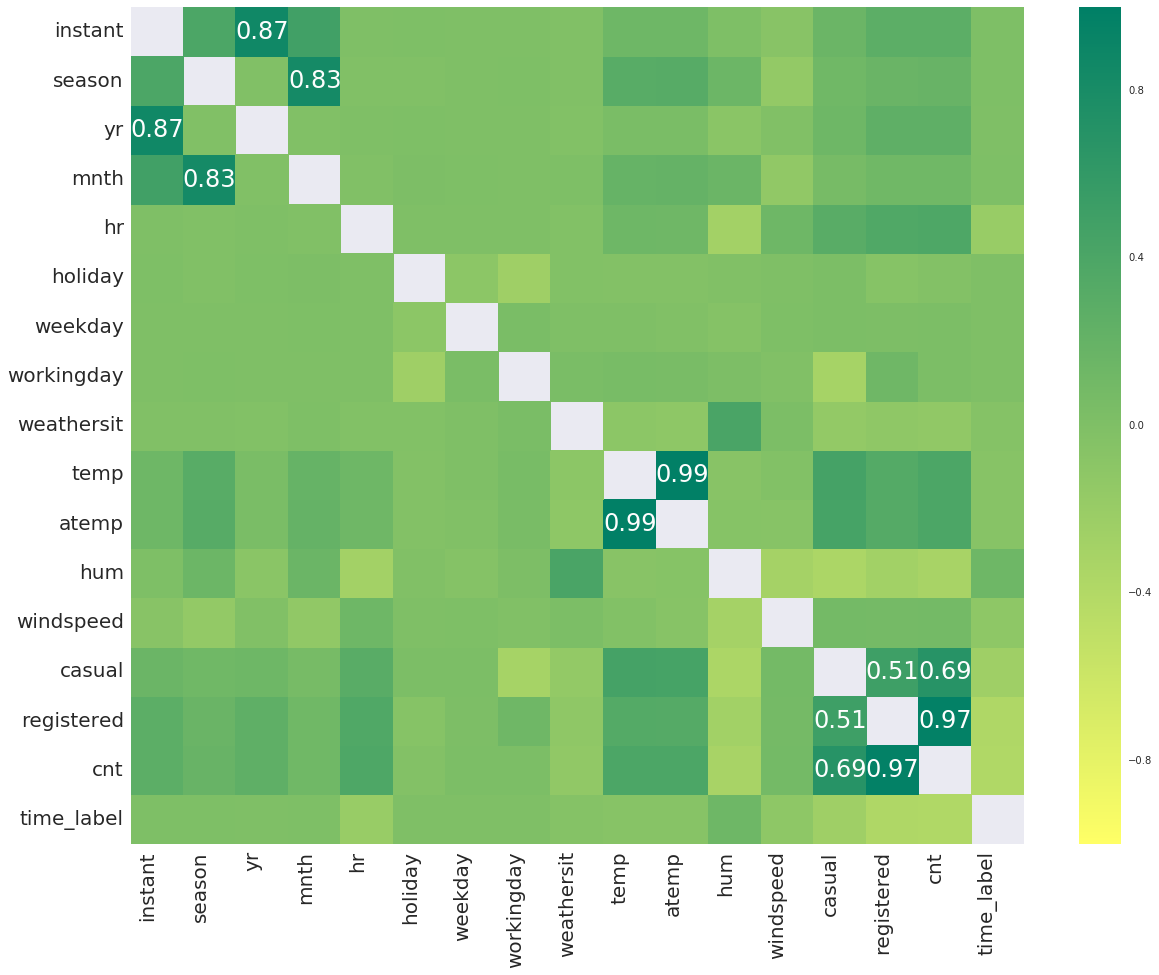

In [10]:
import seaborn as sns

# Plot heatmap
fig = plt.figure(figsize = (20,15))


corr_mat=round(bike_rentals.corr(),2)
mask = corr_mat == 1

# Create labels for annotation only show values of strong correlations
labels = corr_mat.copy()
labels[(abs(labels)<0.5)] = ''

heat_map=sns.heatmap(corr_mat, annot = labels, mask = mask, fmt = '', annot_kws={'fontsize':24}, cmap = 'summer_r')
heat_map.set_xticklabels(heat_map.get_xticklabels(), horizontalalignment='right',rotation=90,fontsize = 20)
heat_map.set_yticklabels(heat_map.get_yticklabels(),fontsize = 20)

To make the feature list following notes are considered:

1. Casual and registered columns will be ignored because cnt is derived from them.
2. temp and atemp columns are highly correlated so one of them is sufficient for prediction. I am going to exclude atemp column.
3. dteday is also excluded since it is not numeric and its data is mentioned in other columns.
4. instant will also be removed since it is only an id.
5. cnt will be removed since it is the target column.

**1. Linear Regression**

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lr=LinearRegression()

features=['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','hum','windspeed','time_label']

lr.fit(train[features],train['cnt'])
linear_predictions_train=lr.predict(train[features])
linear_predictions=lr.predict(test[features])

train_mse=mean_squared_error(train['cnt'],linear_predictions_train)
test_mse=mean_squared_error(test['cnt'],linear_predictions)

train_rmse=train_mse**(1/2)
test_rmse=test_mse**(1/2)

r2_train = r2_score(train['cnt'], linear_predictions_train)
r2_test = r2_score(test['cnt'], linear_predictions)

print('Train_RMSE: ', train_rmse)
print('Train_R2: ', r2_train)
print('\n')
print('Test_RMSE: ', test_rmse)
print('Test_R2: ', r2_test)

Train_RMSE:  132.72098501239842
Train_R2:  0.46934752277845493


Test_RMSE:  130.73388901626132
Test_R2:  0.4609665470190937


**2. Decision Tree**

In [12]:
from sklearn.tree import DecisionTreeRegressor

features=['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','hum','windspeed','time_label']

clf=DecisionTreeRegressor(random_state=1)

clf.fit(train[features],train['cnt'])

train_predictions=clf.predict(train[features])
test_predictions=clf.predict(test[features])

train_mse=mean_squared_error(train['cnt'],train_predictions)
test_mse=mean_squared_error(test['cnt'],test_predictions)

train_rmse=train_mse**(1/2)
test_rmse=test_mse**(1/2)

r2_train = r2_score(train['cnt'], train_predictions)
r2_test = r2_score(test['cnt'], test_predictions)

print('Train_RMSE: ', train_rmse)
print('Train_R2: ', r2_train)
print('\n')
print('Test_RMSE: ', test_rmse)
print('Test_R2: ', r2_test)

Train_RMSE:  0.5693317794626366
Train_R2:  0.9999902352336465


Test_RMSE:  60.902828242349685
Test_R2:  0.8830192827371418


The error is significantly less than the error of the linear regression algorithm. Low training error while validation error is significantly larger shows overfitting. Too high r2 for training (0.99) can also be another sign of overfitting. Let's see if we can tune the model by changing the min_samples_leaf.

In [13]:
clf1=DecisionTreeRegressor(min_samples_leaf=2,random_state=1)

clf1.fit(train[features],train['cnt'])

train_predictions=clf1.predict(train[features])
test_predictions=clf1.predict(test[features])

train_mse=mean_squared_error(train['cnt'],train_predictions)
test_mse=mean_squared_error(test['cnt'],test_predictions)

train_rmse=train_mse**(1/2)
test_rmse=test_mse**(1/2)

r2_train = r2_score(train['cnt'], train_predictions)
r2_test = r2_score(test['cnt'], test_predictions)

print('Train_RMSE: ', train_rmse)
print('Train_R2: ', r2_train)
print('\n')
print('Test_RMSE: ', test_rmse)
print('Test_R2: ', r2_test)

Train_RMSE:  19.087025970711803
Train_R2:  0.9890249240995979


Test_RMSE:  56.55054955043277
Test_R2:  0.8991413810672524


Now we'll twerk min_samples_leaf and see how the error evolves

In [14]:
train_rmses=[]
test_rmses=[]

for i in range(2,20,1):
    clf=DecisionTreeRegressor(min_samples_leaf=i,random_state=1)

    clf.fit(train[features],train['cnt'])

    train_predictions=clf.predict(train[features])
    test_predictions=clf.predict(test[features])

    train_mse=mean_squared_error(train['cnt'],train_predictions)
    test_mse=mean_squared_error(test['cnt'],test_predictions)
    train_rmse=train_mse**(1/2)
    test_rmse=test_mse**(1/2)
    
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)

print('Train_RMSE: ', np.mean(train_rmses))
print('\n')
print('Test_RMSE: ', np.mean(test_rmses))    

Train_RMSE:  41.32057502980713


Test_RMSE:  55.85268480652522


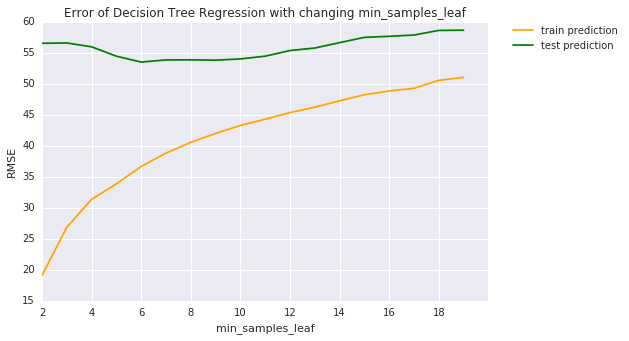

In [15]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1_dt_msl = train_rmses
plt.plot(x,y1_dt_msl, label = 'train prediction', color='orange')
y2_dt_msl = test_rmses
plt.plot(x,y2_dt_msl, label = 'test prediction', color='green')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=0)
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.title("Error of Decision Tree Regression with changing min_samples_leaf")

The validation error decreases from min_samples_leaf of 2 to 6. It almost stagnates for some min_samples_leaf and then increases again. The RMSE of the train set is lower than the RMSE of the test set and increases faster than the validation rate.

Let's see the errors by setting min_samples_leaf = 6.

In [16]:
clf1=DecisionTreeRegressor(min_samples_leaf=6,random_state=1)

clf1.fit(train[features],train['cnt'])

train_predictions=clf1.predict(train[features])
test_predictions=clf1.predict(test[features])

train_mse=mean_squared_error(train['cnt'],train_predictions)
test_mse=mean_squared_error(test['cnt'],test_predictions)

train_rmse=train_mse**(1/2)
test_rmse=test_mse**(1/2)

r2_train = r2_score(train['cnt'], train_predictions)
r2_test = r2_score(test['cnt'], test_predictions)

print('Train_RMSE: ', train_rmse)
print('Train_R2: ', r2_train)
print('\n')
print('Test_RMSE: ', test_rmse)
print('Test_R2: ', r2_test)

Train_RMSE:  36.67688667014959
Train_R2:  0.9594756618899392


Test_RMSE:  53.520581428325
Test_R2:  0.9096598092459718


Comparing with the decision tree with the default setting, all the metrics have been improved:

* Lower validation error
* Significantly lower difference between errors
* More reasonable r2 but still high

Generally, the algorithm is tuned to prevent overfitting but still overfit.

Let's keep min_samples_leaf = 6 and change max_depth.

In [17]:
train_rmses=[]
test_rmses=[]

for i in range(2,20,1):
    clf=DecisionTreeRegressor(min_samples_leaf=6,max_depth=i,random_state=1)

    clf.fit(train[features],train['cnt'])

    train_predictions=clf.predict(train[features])
    test_predictions=clf.predict(test[features])

    train_mse=mean_squared_error(train['cnt'],train_predictions)
    test_mse=mean_squared_error(test['cnt'],test_predictions)
    train_rmse=train_mse**(1/2)
    test_rmse=test_mse**(1/2)
    
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)

print('Train_RMSE: ', np.mean(train_rmses))
print('\n')
print('Test_RMSE: ', np.mean(test_rmses))

Train_RMSE:  67.14661473045366


Test_RMSE:  75.84503524823927


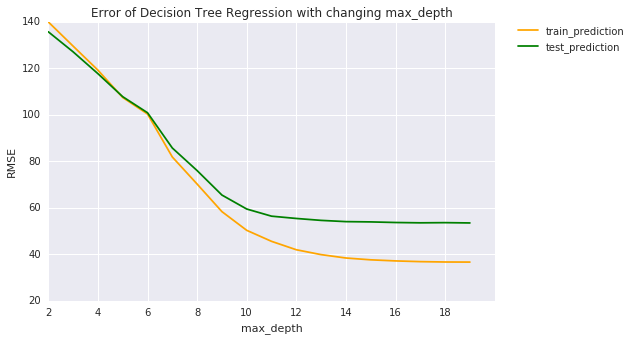

In [18]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1_dt_md = train_rmses
y2_dt_md = test_rmses
plt.plot(x,y1_dt_md, color='orange', label = 'train_prediction')
plt.plot(x,y2_dt_md, color='green', label = 'test_prediction')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=0)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.title("Error of Decision Tree Regression with changing max_depth")

According to the above plot when max_depth is 6 the difference between validation and training errors is very low which is good but the errors are high. When max_depth is 10 the errors are decreased significantly but the difference between errors does not increase too much. Let's compare the metrics against previous simulations max_depth 10.

In [19]:
clf1=DecisionTreeRegressor(min_samples_leaf=6,random_state=1,max_depth=10)

clf1.fit(train[features],train['cnt'])

train_predictions=clf1.predict(train[features])
test_predictions=clf1.predict(test[features])

train_mse=mean_squared_error(train['cnt'],train_predictions)
test_mse=mean_squared_error(test['cnt'],test_predictions)

train_rmse=train_mse**(1/2)
test_rmse=test_mse**(1/2)

r2_train = r2_score(train['cnt'], train_predictions)
r2_test = r2_score(test['cnt'], test_predictions)

print('Train_RMSE: ', train_rmse)
print('Train_R2: ', r2_train)
print('\n')
print('Test_RMSE: ', test_rmse)
print('Test_R2: ', r2_test)

Train_RMSE:  50.35225112753489
Train_R2:  0.9236219112328659


Test_RMSE:  59.51177300046723
Test_R2:  0.8883020671357731


Comparing this model with the decision tree with the same min_sample_leaf = 6 but with no limitation on max_depth, I can say although the errors are higher the difference between errors is lower and r2 values are more reasonable(0.92, 0.88) in comparison of (0.96, 0.91). So the model is generalized and fitted better than the previous one.

Let's try the random forest algorithm to see if it helps to improve the results.

**3. Random Forest**

In [20]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_model(train, test, feature, target, min_samples_leaf = 2, max_depth = None):
    rf = RandomForestRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    rf.fit(train[features], train[target])
    predictions = rf.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

print('Train_MSE: ',random_forest_model(train,train,features,'cnt')[0])
print('Train_R2: ',random_forest_model(train,train,features,'cnt')[1])
print('\n')
print('Test_MSE: ', random_forest_model(train,test,features,'cnt')[0])
print('Test_R2: ',random_forest_model(train,test,features,'cnt')[1])

Train_MSE:  24.559545202129687
Train_R2:  0.9818293005969096


Test_MSE:  45.910358627951695
Test_R2:  0.9335246353758139


Training and validation errors are significantly lower but the difference between errors is higher. R squares seem too high as well. Let's see if we can tune this model to get better results. First I am going to change min_sample_leaf and then max_dept.

In [21]:
train_rmses = []
test_rmses = []
for i in range(2, 20, 1):
    train_error = random_forest_model(train, train, features, 'cnt', i, None)
    test_error = random_forest_model(train, test, features, 'cnt', i, None)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])

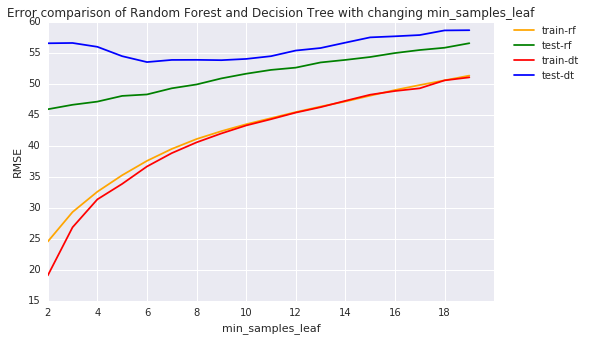

In [22]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1 = train_rmses
y2 = test_rmses
plt.plot(x,y1, color='orange', label = 'train-rf')
plt.plot(x,y2, color='green', label = 'test-rf')
plt.plot(x,y1_dt_msl, color='red', label = 'train-dt')
plt.plot(x,y2_dt_msl, color='blue', label = 'test-dt')
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)
plt.title('Error comparison of Random Forest and Decision Tree with changing min_samples_leaf')

The above plot shows clearly that the random forest model gives lower validation errors than the decision tree. The difference between errors is also decreased for all min_samples_leaf so the random forest seems more fitted. Let's choose min_samples_leaf = 6 and change max_depth to see if we can get better results.

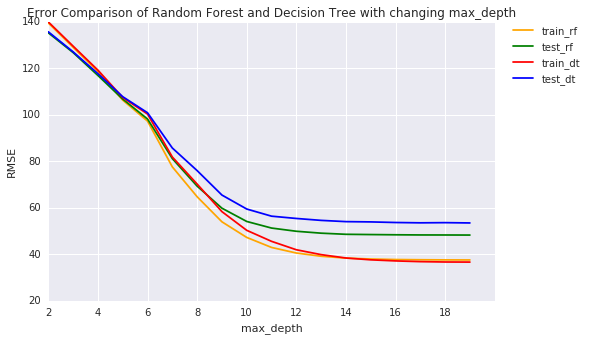

In [23]:

plt.figure(figsize=(8, 5))
train_rmses = []
test_rmses = []
for i in range(2, 20, 1):
    train_error = random_forest_model(train, train, features, 'cnt', 6, i)
    test_error = random_forest_model(train, test, features, 'cnt', 6, i)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])
    
x = range(2, 20, 1)
y1 = train_rmses
y2 = test_rmses
plt.plot(x,y1, color='orange', label = 'train_rf')
plt.plot(x,y2, color='green', label = 'test_rf')
plt.plot(x,y1_dt_md, color='red', label = 'train_dt')
plt.plot(x,y2_dt_md, color='blue', label = 'test_dt')

plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.title('Error Comparison of Random Forest and Decision Tree with changing max_depth')

The above plot shows random forest gives lower errors than the decision tree. Let's look at the result of the random forest when min_samples_leaf = 6 and max_depth = 10 and compare with the decision tree with the same values.

In [24]:
#MAX DEPTH = 10

print('Train_MSE: ',random_forest_model(train,train,features,'cnt',6,10)[0])
print('Train_R2: ',random_forest_model(train,train,features,'cnt',6,10)[1])
print('\n')
print('Test_MSE: ', random_forest_model(train,test,features,'cnt',6,10)[0])
print('Test_R2: ',random_forest_model(train,test,features,'cnt',6,10)[1])

Train_MSE:  47.299480723354996
Train_R2:  0.9326025059172808


Test_MSE:  54.165782642968104
Test_R2:  0.9074685425022407


### Conclusion

In this project, I have tried some mdels to predict bike rentals. Let's compare the models I have tried in one table using the following abreviations:

* LR: Linear Regreassion
* DT: Decision Tree Regression
* RF: Random Forest

In [25]:
algorithms = pd.DataFrame(index = ['LR', 'DT Default', 'DT with min_samples_leaf = 6', 'DT with min_samples_leaf = 6 and max_depth = 10', 'RF Default', 'RF with min_samples_leaf = 6 and max_depth = 10'],
            columns = ['train_rsme', 'train_r2', 'test_rsme', 'test_r2'], 
            data = np.array([[132.72, 0.47, 130.73, 0.46],
                             [0.57, 0.99, 60.90, 0.88],
                             [36.68, 0.96, 53.52, 0.91],
                             [50.35, 0.92, 59.51, 0.88],
                             [24.56, 0.98, 45.91, 0.93],
                             [47.29, 0.93, 54.16, 0.91]]))
algorithms

,train_rsme,train_r2,test_rsme,test_r2
LR,132.72,0.47,130.73,0.46
DT Default,0.57,0.99,60.90,0.88
DT with min_samples_leaf = 6,36.68,0.96,53.52,0.91
DT with min_samples_leaf = 6 and max_depth = 10,50.35,0.92,59.51,0.88
RF Default,24.56,0.98,45.91,0.93
RF with min_samples_leaf = 6 and max_depth = 10,47.29,0.93,54.16,0.91


Among the above models **Random Forest with min_samples_leaf = 6 and max_depth = 8** has shown the best result. Although some other models show lower errors they seem overfitted because of too high r square and higher training error than validation error. This result has been achieved by applying trade-off between the following criteria:

* Lower RSME
* Lower difference between training and validation errors to prevent overfitting
* High R square but not too high to find the fitted algorithm but not overfitted one.